In [39]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd

In [40]:
user='S'

if user=='S':
    lien="C:/Users/sylva/Desktop/git/Projet-Python-deputes/"
elif user=='G':
    lien="C:/Users/Administrateur.LAPTOP-FH8TB47B/Desktop/Projet_assemblee/"
    
mandat_dep=pd.read_csv(lien+"liste_mandatdef.csv")#on récupère le csv de la liste des mandats
df_depu=pd.read_csv(lien+"listeDepute_complete.csv")
table_depmt=pd.read_csv(lien+"table_dpmt.csv")

### Les caractéristiques des départements

**Objectif** : On s'intéresse tout d'abord à quelques indicateurs sur le "nombre moyen de mandat par député", donc un indicateur du taux de réelection des députés, par département.

On se limite aux plus gros départements (ayant eu au moins 41 députés) pour éviter de prendre en compte les départements qui ont disparu trop vite.

In [41]:
table_depmt.set_index("Unnamed: 0", inplace=True)

In [42]:
print("Le nombre minimum de département par député est", min(table_depmt.loc['nombre moyen de mandats par député'][table_depmt.loc['nombre député']>40]))
print("Ce nombre maximum est", max(table_depmt.loc['nombre moyen de mandats par député'][table_depmt.loc['nombre député']>40]))
print("Le nombre moyen de mandats par député sur tout les département est", (table_depmt.loc['nombre moyen de mandats par député'][table_depmt.loc['nombre député']>40]).mean())
print("Le nombre de département ayant moins de deux réélections par député en moyenne est", (table_depmt.loc['nombre moyen de mandats par député'][table_depmt.loc['nombre moyen de mandats par député']<2][table_depmt.loc['nombre député']>40]).count())

Le nombre minimum de département par député est 1.0
Ce nombre maximum est 3.09375
Le nombre moyen de mandats par député sur tout les département est 2.290677795052528
Le nombre de département ayant moins de deux réélections par député en moyenne est 5


**Analyse** : Il semble a priori que la plupart des département ont un taux de réélection proche de 2. Intéressons nous plus spécifiquement aux valeurs extrêmes.

In [43]:
table_depmt.loc['nombre moyen de mandats par député'][table_depmt.loc['nombre député']>40].sort_values().head()

 Départements de l'Empire français aujourd'hui en Italie      1.000000
 Départements de l'Empire français aujourd'hui en Belgique    1.180723
 Anciens départements d'Algérie                               1.526570
 Allier                                                       1.974843
 Meurthe                                                      1.986486
Name: nombre moyen de mandats par député, dtype: float64

In [44]:
table_depmt.loc['nombre moyen de mandats par député'][table_depmt.loc['nombre député']>40].sort_values().tail()

 Hauts-de-Seine    2.746269
 Val-de-Marne      2.770833
 La Réunion        2.780000
 Haute-Savoie      2.827586
 Savoie            3.093750
Name: nombre moyen de mandats par député, dtype: float64

**Analyse** : Les valeurs les plus basses sont constituées par des départements qui ont appartenu peu de temps à la France, et où les occasions de se faire réélire ont donc été peu nombreuses. Au contraire, les départements où il y a le plus de réélections ne semblent pas avoir de problèmes de ce type.

**Représentation graphique** : Voici à quoi ressemble la répartion du taux de réelection selon les départements. Elle est bien centré sur une valeur proche de 2 et à très peu de valeurs extrêmes

<AxesSubplot:>

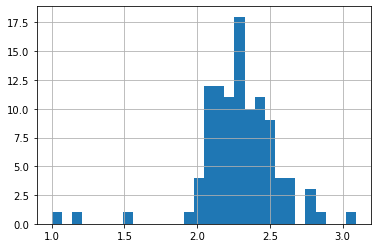

In [45]:
 table_depmt.loc['nombre moyen de mandats par député'][table_depmt.loc['nombre député']>40].hist(bins=30)

**Représentation graphique** : on peut visualiser cela sous la forme d'une carte.

In [46]:
#récupération d'une carte des départements français
import requests
import tempfile
import zipfile

temporary_location = tempfile.gettempdir()
def download_unzip(url, dirname =temporary_location, destname = "borders"):#fonction qui dézippe
    myfile = requests.get(url)
    open(dirname + '/' + destname + '.zip', 'wb').write(myfile.content)
    with zipfile.ZipFile(dirname + '/' + destname + '.zip', 'r') as zip_ref: 
        zip_ref.extractall(dirname + '/' + destname)
download_unzip('https://www.data.gouv.fr/fr/datasets/r/3096e551-c68d-40ce-8972-a228c94c0ad1')#l'URL où on trouve les départements


Cette carte est issue de :"© les contributeurs d'OpenStreetMap sous licence ODbL"

In [47]:
carte_departement = gpd.read_file(tempfile.gettempdir() + "/borders/departements-20140306-100m.dbf")#on va chercher le fichier là où on l'a stocké
carte_metrop = carte_departement.loc[0:95]#on enlève les départements d'outre-mer pour avoir une carte lisible


In [48]:
table_depmt.columns=[i[1:] for i in table_depmt.columns]#on enlève l'espace devant le nom des départements

In [49]:
carte_metrop.set_index('nom', inplace=True)#on met le nom du département en index pour pouvoir joindre les bases

<AxesSubplot:>

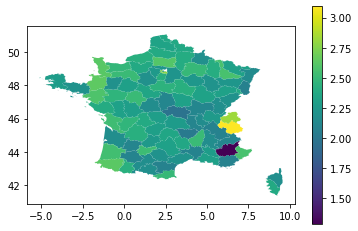

In [50]:
df = carte_metrop.merge(table_depmt.T, how = 'inner', left_index=True, right_index=True)#on transpose table pour avoir les départements en noms de lignes
df.plot(column = 'nombre moyen de mandats par député', cmap = 'viridis', legend=True)#on crée des cartes

**Représentation graphique** : On peut alors facilement obtenir une carte similaire avec l'âge moyen des députés lors de leur mandat.

<AxesSubplot:>

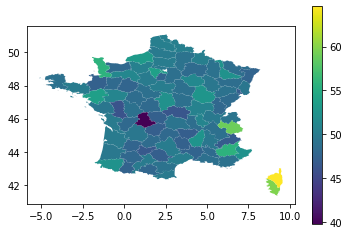

In [51]:
df.plot(column = 'age moyen des deputes', cmap = 'viridis', legend=True)#on crée des cartes

_Problème_ : La corse du Nord semble avoir une valeur trop élevé, regardons plus précisément d'où elle vient

In [52]:
mandat_dep[mandat_dep["Département"]==' Haute-Corse'].sort_values(by="age en année").tail(4)[["Nom","age en année"]]

KeyError: 'age en année'

In [53]:
mandat_dep[mandat_dep["Département"]==' Haute-Corse']["age en année"].describe()

KeyError: 'age en année'

Finalement, on observe que la Haute-Corse a bien des députés vieux et une valeur aberrante avec ce Paul Giacobbi. L'origine de cette erreur est expliquée dans le fichier 'analyse na'.

**Représentation graphique** : On peut aussi voir que des département historiquement plus peuplés comme la région parisienne et le nord sont surreprésentés dans notre base via une carte représentant le nombre de mandat dans la base par département.

<AxesSubplot:>

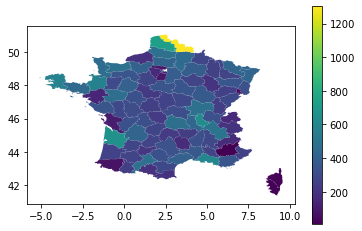

In [54]:
df.plot(column = 'nombre_mandat', cmap = 'viridis', legend=True)#on crée des cartes

### Réélection entre les régimes

**Fabrication de la base d'intérêt 1**:  Récupération des différents régimes des députés à partir de la liste de wikipédia

In [55]:
lstRegime=pd.read_csv("C:/Users/Administrateur.LAPTOP-FH8TB47B/Desktop/Projet_assemblee/regime_wiki.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Administrateur.LAPTOP-FH8TB47B/Desktop/Projet_assemblee/regime_wiki.csv'

In [198]:
def TrouverRegime(x):
    regime=lstRegime['Nom'][0]
    i=0    
    while (not (x<lstRegime['Date Fin'][i])) and i<=11:#jusqu'à ce que l'on trouve le premier régime ayant commencé après l'élection 
        i+=1#on essaie avec le suivant
        regime=lstRegime['Nom'][i]
    return regime

In [199]:
Regime_depute=mandat_dep[~mandat_dep["Date debut mandat"].isna()]

In [200]:
Regime_depute['Régime']=Regime_depute['Date debut mandat'].apply(lambda x : TrouverRegime(x))

<ipython-input-200-31db24dbc345>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Regime_depute['Régime']=Regime_depute['Date debut mandat'].apply(lambda x : TrouverRegime(x))


**2)** Construction de la base avec les caractéristiques des différents régime

In [201]:
reg_possible=list(Regime_depute['Régime'].unique())#une liste de tous les régimes
reg_possible.reverse()#on les met dans l'ordre chronologique
df=Regime_depute.reset_index()
v,w,x,y,z,a,b,c,d=[],[],[],[],[],[],[],[],[]
for reg in reg_possible :
    v+=[float(lstRegime[lstRegime['Nom']==reg]['Durée en année'])]#la durée du régime
    w+=[df[df['Régime']==reg]['age en année'].mean()]#on prend la moyenne d'age dans ce régime
    x+=[len(df[df['Régime']==reg])]#on compte le nombre total de mandat dans le régime
    y+=[len(df[df['Régime']==reg]['Nom'].unique())]#Puis le nombre de députés différent
    z+=[x[-1]/y[-1]] #Ceci est le nombre moyen de mandat par député
    a+=[x[-1]/v[-1]]#le nombre moyen de mandat par an
    b+=[len(Regime_depute[Regime_depute['Régime']==reg]['Législature'].unique())]
    c+=[x[-1]/b[-1]]#nombre moyen de mandats par législature
    d+=[v[-1]/b[-1]]#durée moyenne d'une législature
    
carac_reg_bis=np.array([v, w, x, y, z, a, b, c, d])#on crée un dataframe avec les informations
table_reg = pd.DataFrame(carac_reg_bis, index=['durée du régime', 'age moyen des deputes', 'nombre_mandat', 'nombre député','nombre moyen de mandats par député', 'nombre moyen de mandats par an', 'nombre de législature', 'nombre moyen de mandats par législature', 'durée moyenne de législature'],columns=reg_possible).T
table_reg



,durée du régime,age moyen des deputes,nombre_mandat,nombre député,nombre moyen de mandats par député,nombre moyen de mandats par an,nombre de législature,nombre moyen de mandats par législature,durée moyenne de législature
Première Restauration,0.791239,51.067422,258.0,240.0,1.075000,326.070934,2.0,129.000000,0.395619
Cent-Jours,0.298426,47.485411,325.0,314.0,1.035032,1089.048165,1.0,325.000000,0.298426
Seconde Restauration,14.507871,52.205648,2562.0,1417.0,1.808045,176.593791,5.0,512.400000,2.901574
Monarchie de Juillet,17.462012,49.384249,3750.0,1462.0,2.564979,214.751881,7.0,535.714286,2.494573
Deuxième République,3.967146,45.702348,1796.0,1349.0,1.331357,452.718427,2.0,898.000000,1.983573
Second Empire,18.154689,51.336521,1296.0,608.0,2.131579,71.386518,4.0,324.000000,4.538672
Premier Empire,9.878166,41.652390,4038.0,2793.0,1.445757,408.780349,6.0,673.000000,1.646361
Troisième République,70.494182,49.349630,11513.0,4893.0,2.352953,163.318442,17.0,677.235294,4.146717
Gouvernement provisoire de la République française,2.642026,45.263814,1841.0,842.0,2.186461,696.813731,3.0,613.666667,0.880675
Quatrième République,11.452430,48.876792,1385.0,931.0,1.487648,120.935035,5.0,277.000000,2.290486


In [202]:
table_longreg=table_reg[table_reg['durée du régime']>10] #On crée une table avec seulement les régimes les plus longs

**Réprésentation graphique** : on peut ainsi voir l'évolution des taux de réélection selon les régimes 

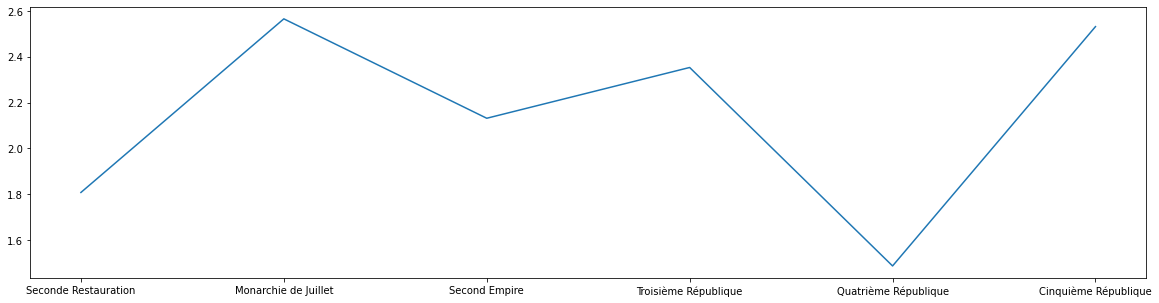

In [203]:
plt.figure(figsize=(20,5))
plt.plot(table_longreg["nombre moyen de mandats par député"])
plt.title("nombre moyen de mandats par députés selon le régime")

**Analyse** : on retrouve le fait bien connu d'une plus grande instabilité politique lors de la quatrième république, avec beaucoup moins de réélection.

### Analyse des évolutions des régimes

In [204]:
listeLegis=['Ire','IIe', 'IIIe', 'IVe', 'Ve', 'VIe', 'VIIe', 'VIIIe', 'IXe', 'Xe', 'XIe', 'XIIe', 'XIIIe', 'XIVe', 'XVe', 'XVIe']
listeLegislature=[' '+i+' législature ' for i in listeLegis]#on crée une liste des législatures dans le bon ordre

In [205]:
#on va s'intéresser aux législatures des régimes qui ont duré longtemps
dept_naiss_3=Regime_depute[Regime_depute['Régime'] =='Troisième République']
dept_naiss_5=Regime_depute[Regime_depute['Régime'] =='Cinquième République']
dept_naiss_emp2=Regime_depute[Regime_depute['Régime'] =='Second Empire']
diffdep_3=[]#le nombre de députés dans la base pour les législatures i et i+1 pour la Troisième République
diffdep_5=[]#pour la Cinquième
diffdep_emp2=[]#pour le second Empire
[tauxreelec_3,tauxreelec_5, tauxreelec_emp2]=[[],[],[]]#le taux de réelection entre les législatures i et i+1 pour la troisième République
[date_leg_3, date_leg_5,date_leg_emp2]=[[],[],[]]#les dates de début de législatures


def data_legis(compteur, dept_naissance, diffdep, tauxreelec, date_leg):
    passation=pd.concat((dept_naissance[dept_naissance['Législature'] ==listeLegislature[compteur]],dept_naissance[dept_naissance['Législature']==listeLegislature[compteur+1]]))

    if not dept_naissance[dept_naissance['Législature']==listeLegislature[compteur+1]]['Date debut mandat'].empty :#s'il y a deux législatures à comparer :
        nbredep=passation['Nom'].count()
        diffdep+=[nbredep]
        tauxreelec+=[passation['Nom'].unique().shape[0]/nbredep]
        date_leg+=[pd.to_datetime(min(passation.tail(1)['Date debut mandat'])).year]
    return diffdep, tauxreelec, date_leg
            
for compteur in range(len(listeLegislature)-1) :
    data_legis(compteur, dept_naiss_3, diffdep_3, tauxreelec_3, date_leg_3)
    data_legis(compteur, dept_naiss_5, diffdep_5, tauxreelec_5, date_leg_5)
    data_legis(compteur, dept_naiss_emp2, diffdep_emp2, tauxreelec_emp2, date_leg_emp2)

print(diffdep_5)#on a une bonne base jusqu'à la douzième législature pour la 5e République, avec une grande majorité des députés présents dans la base   
print(diffdep_emp2)

[1206, 1120, 1153, 1231, 1190, 1149, 1243, 1326, 1375, 1330, 1256, 1063, 662, 241]
[648, 677, 648]


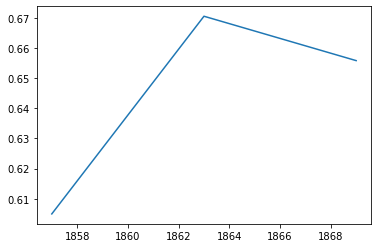

In [206]:
plt.plot(date_leg_emp2,tauxreelec_emp2)
plt.title(réelection des députés sous le Second Empire)

**Analyse** : Où on voit l'Empire qui s'embourgeoise...

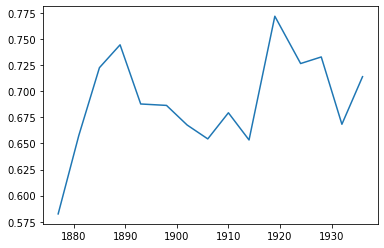

In [183]:
plt.plot(date_leg_3, tauxreelec_3)
plt.title("taux de réelection des députés sous la Troisième République")

**Analyse** : On peut voir l'impact de l'affaire Dreyfus et de la Première Guerre Mondiale, et les scandales des années 30.

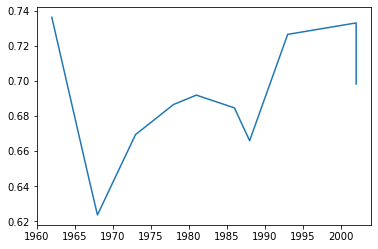

In [184]:
plt.plot(date_leg_5[:11], tauxreelec_5[:11])
plt.title("taux de réelection des députés sous la Cinquième République")

**Analyse** : On voit un effet mai 68, puis un début de professionnalisation de la politique.  

### Analyse de l'origine des députés

In [208]:
def pourcentageTerroir(basedep) :#une fonction qui donne le pourcentage de mandats occupés par des députés nés dans leur département d'élection
    basedep_1=basedep[basedep['Département']==' '+basedep['Département de naissance']]
    nbreterroir=basedep_1[basedep_1['Département de naissance']!='Inconnu']['Département'].count()
    pourcTerroir=nbreterroir/basedep[basedep['Département de naissance']!='Inconnu']['Département'].count()
    return pourcTerroir
pourcentageTerroir(Regime_depute)

0.5205359925210346

environ un député sur deux dont on connait le département de naissance s'est fait élire dans ce département

In [209]:
regterroir=[]
for regime in reg_possible :
    regterroir+=[pourcentageTerroir(Regime_depute[Regime_depute['Régime']==regime])]

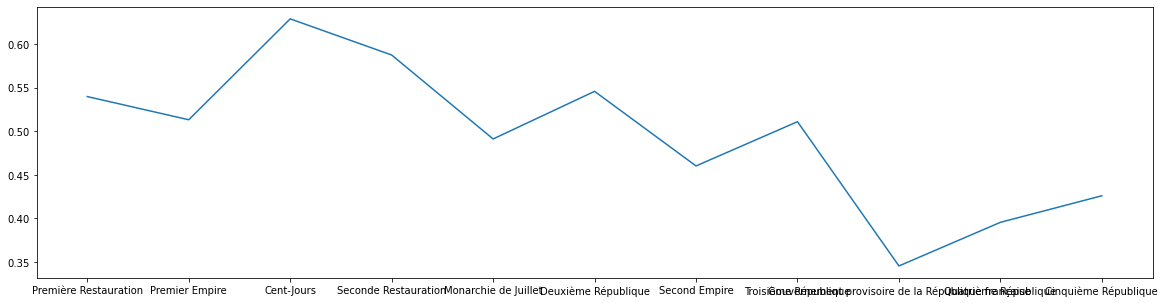

In [38]:
plt.figure(figsize=(20,5))
plt.plot(reg_possible, regterroir)
plt.title("taux de députés élus dans leur département de naissance selon le régime")

**Analyse** : On a une tendance à la baisse, avec un taux historiquement bas lors de GPRF (où l'on avait d'autres problèmes). Cela mis à part, les deux Républiques succédant à d'autres régimes semblent faire remonter ce taux.

_Problème_ : ces résultats sont à prendre avec beaucoup de précaution du fait des valeurs manquantes en fin de période.

In [211]:
[pcterroir_3, pcterroir_5, pcterroir_emp2]=[[],[],[]]#le pourcentage de députés élus dans leur région de naissance
[date_leg_3, date_leg_5, date_leg_emp2]=[[],[],[]]
def dataparreg (basereg, pcterroir, date_leg) :
    for legislatures in range(len(listeLegislature)):
        if not basereg[basereg['Législature'] ==listeLegislature[legislatures]].empty :
            basedep=basereg[basereg['Législature'] ==listeLegislature[legislatures]]
            pcterroir+=[pourcentageTerroir(basedep)]
            date_leg+=[pd.to_datetime(min(basedep.tail(1)['Date debut mandat'])).year]
dataparreg(dept_naiss_3, pcterroir_3, date_leg_3)
dataparreg(dept_naiss_5, pcterroir_5, date_leg_5)
dataparreg(dept_naiss_emp2, pcterroir_emp2, date_leg_emp2)

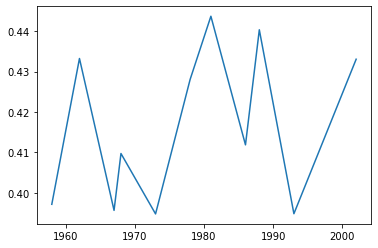

In [40]:
plt.plot(date_leg_5[:11], pcterroir_5[:11])
plt.title("taux de députés élus dans leur département de naissance durant la Cinquième République")

**Analyse** : Pas beaucoup d'effet observable, peut être aussi à cause des valeurs manquantes

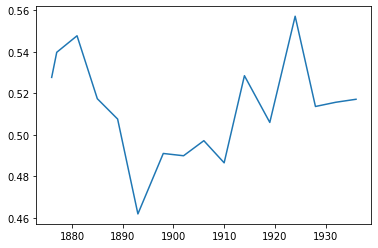

In [46]:
plt.plot(date_leg_3, pcterroir_3)
plt.title("taux de députés élus dans leur département de naissance durant la Troisième République")

**Analyse** : une chute au moment de l'affaire Dreyfus... Mais surtout des valeurs toujours supérieures à celles de la Cinquième République ! Les temps ont changé, l'ancrage local est devenu moins important entre les deux régimes.

### Analyse des réélection entre les différents régime

Etude des réelections entre différents régimes (attention au changement de nombre de députés ! Plutôt à prendre qualitativement, avec les grandes tendances, que quantitativement).

In [216]:
def Recuplegtrans (transition, premier=True) :
    if premier :
        base_transreg1=Regime_depute[Regime_depute['Régime']==reg_possible[transition]]#on récupère la base du régime voulu
        date_trans1=max(base_transreg1['Date debut mandat'])#on prend la date la plus élevée
    else:
        base_transreg1=Regime_depute[Regime_depute['Régime']==reg_possible[transition+1]]#on récupère la base du régime voulu
        date_trans1=min(base_transreg1['Date debut mandat'])#on prend la date la plus élevée
    leg_trans1=base_transreg1[base_transreg1['Date debut mandat']==date_trans1]['Législature'].unique()#pour récupérer la législature voulue
    base_trans1=base_transreg1[base_transreg1['Législature']==leg_trans1[0]]#et on prend les données des députés de cette dernière législature
    return base_trans1

In [217]:
pctreelec=[]
nbremand=[]
nbredepu=[]
for transition in range(len(reg_possible)-1) :
    base=pd.concat((Recuplegtrans(transition),Recuplegtrans(transition, False)))#on prend la dernière législature du régime précédent et la première du nouveau
    nbremand+=[base['Nom'].count()]
    nbredepu+=[base['Nom'].unique().shape[0]]
    pctreelec+=[float(nbremand[-1])/float(nbredepu[-1])]
print(pctreelec)

[1.0338461538461539, 1.0389610389610389, 1.0959367945823928, 1.140687450039968, 1.1271676300578035, 1.0313807531380754, 1.0223880597014925, 1.1312775330396476, 1.0193548387096774, 1.1981308411214953]


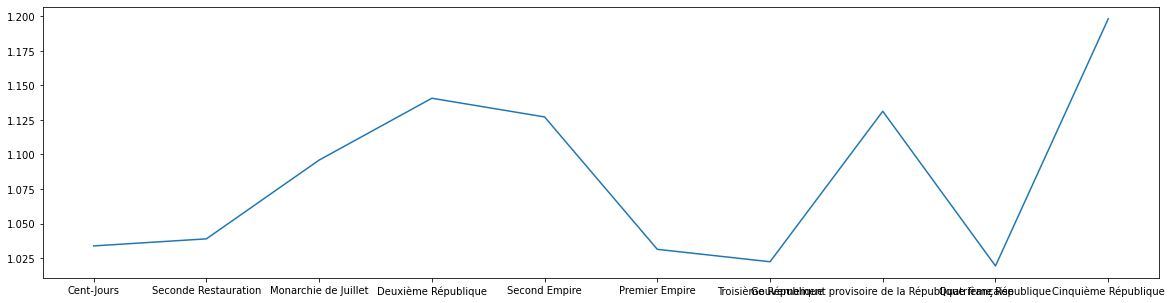

In [218]:
plt.figure(figsize=(20,5))
plt.plot(reg_possible[1:],pctreelec)
plt.title("taux de réelection de la première législature de chaque régime par rapport à la dernière du régime précédent")

**_Lecture_** : la monarchie de Juillet a réélu moins de députés provenant de la seconde restauration que la cinquième république n'a réélu de députés de la Quatrième.

**Analyse** : la Quatrième République a très peu réélu les députés du GPRF, le Second Empire a beaucoup réélu les députés de la Deuxième République (qui ont plébiscité Napoléon III).

### Analyse des groupes parlementaires 

Statistiques préliminaires :

In [227]:
print("Il y a",dept_naiss_3[dept_naiss_3['Législature']==' XVIe législature ']['Groupe'].unique().shape[0], "groupes dans la quatorzième législature de la troisième république.")

Il y a 25 groupes dans la quatorzième législature de la troisième république.


In [228]:
print("Il y a", Regime_depute[Regime_depute['Régime']=='Seconde Restauration']['Groupe'].unique().shape[0], "groupes différents dans le second Empire.")

Il y a 88 groupes différents dans le second Empire.


**Objectif** : analyser l'évolution du nombre de groupe aux seins des différent régime

Cette fonction à pour but de trouver le nombre de groupe par législature

In [221]:
def Statgroupe (base_dep, mandatgroupe=True):
    nbregrleg=[]#nombre de groupe par législature
    nbremandgr=[]#nombre de mandat par groupe
    date_leg=[]
    for legislature in base_dep['Législature'].unique() :
        baseleg=base_dep[base_dep['Législature']==legislature]
        nbregrleg+=[baseleg['Groupe'].unique().shape[0]]
        if mandatgroupe:
            date_leg+=[pd.to_datetime(min(baseleg['Date debut mandat'].tail(1))).year]
    totgroupe=base_dep['Groupe'].unique().shape[0]
    moydureegr=sum(nbregrleg)/totgroupe#le nombre moyen de législature d'un groupe correspond à la somme du nombre de groupes sur les législatures / le nombre total de groupe
    if mandatgroupe :
        for groupe in base_dep['Groupe'].unique() :
            nbremandgr+=[base_dep[base_dep['Groupe']==groupe]['Groupe'].count()]
        return nbregrleg, nbremandgr, moydureegr, date_leg
                    
    return nbregrleg, moydureegr

In [222]:
(groupeleg_3, mandatgroupe_3, moydureegr_3, date_leg_3)=Statgroupe(dept_naiss_3)
(groupeleg_5, mandatgroupe_5, moydureegr_5, date_leg_5)=Statgroupe(dept_naiss_5)


In [49]:
pluralisme=[]
for regime in reg_possible:
    data=[Statgroupe(dept_naiss[dept_naiss['Régime']==regime], False)]
    nbregrleg =data[0][0]
    dureegroupe=data[0][1]
    pluralisme+=[sum(nbregrleg)/len(nbregrleg)]#on fait une moyenne sur les législatures du nombre de groupes différents

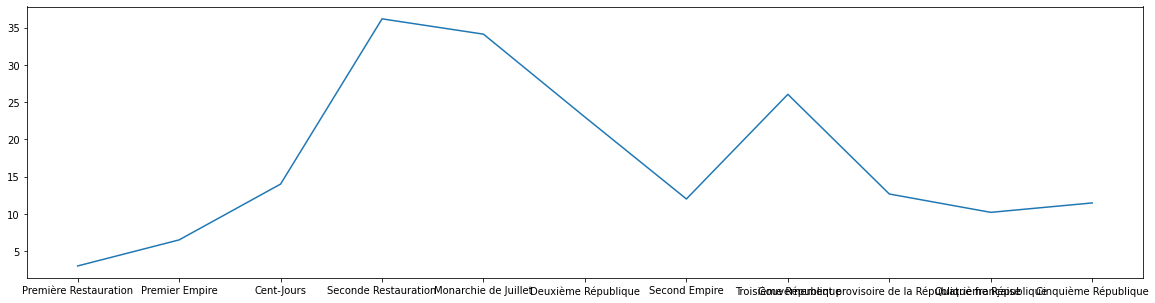

In [50]:
plt.figure(figsize=(20,5))
plt.plot(reg_possible,pluralisme)
plt.title("nombre de groupes parlementaires moyen par législature selon le régime")

**Analyse** : Etonnamment, les régimes ayant le plus de groupes parlementaires ne sont pas des Républiques, mais les monarchies constitutionnelles.

<Figure size 1440x360 with 0 Axes>

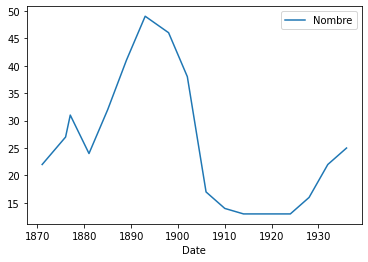

In [123]:
plt.figure(figsize=(20,5))
base=pd.DataFrame([np.array(date_leg_3),np.array(groupeleg_3)], index=['Date','Nombre'])
base=base.sort_values(by=['Date'],axis=1)

base.T.plot(x='Date',y='Nombre')
plt.title("nombre de groupes parlementaires par législature de la Troisième République")

<Figure size 1440x360 with 0 Axes>

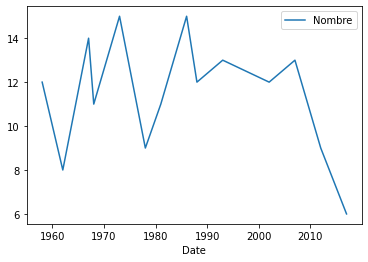

In [124]:
plt.figure(figsize=(20,5))
base=pd.DataFrame([np.array(date_leg_5),np.array(groupeleg_5)], index=['Date','Nombre'])
base=base.sort_values(by=['Date'],axis=1)

base.T.plot(x='Date',y='Nombre')
plt.title("nombre de groupes parlementaires par législature de la Cinquième République")

**Analyse** :Un nombre de groupe parlementaire bien moins élevé que dans la Troisième République (connue pour ses interminables querelles de partis) 

**Remarque**: Cette analyse comporte une limite importante : de très nombreux groupes sont en fait représenté par très peu de député, ce qui rend difficile une interprétation telle quelle du nombre de groupe. Les règles institutionnelles ont aussi changé : il faut aujourd'hui un nombre minimal de députés pour constituer un groupe parlementaire.

Text(0.5, 1.0, 'Les différentes tailles de groupes parlementaires dans la Troisième République')

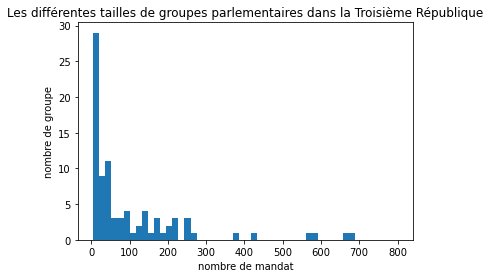

In [237]:
mandat_groupe_3=np.array(mandatgroupe_3)
plt.hist(mandat_groupe_3, range=(5, 800), bins = 50)
plt.title('Les différentes tailles de groupes parlementaires')
plt.xlabel('nombre de mandat')
plt.ylabel('nombre de groupe')
plt.title('Les différentes tailles de groupes parlementaires dans la Troisième République')

Text(0.5, 1.0, 'Les différentes tailles de groupes parlementaires dans la Cinquième République')

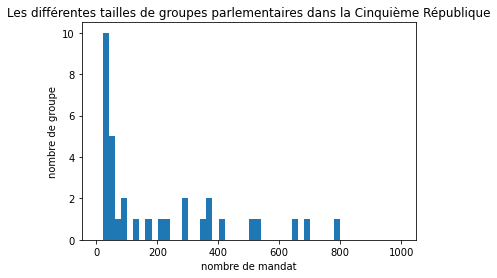

In [147]:
mandat_groupe_5=np.array(mandatgroupe_5)[np.array(mandatgroupe_5) >20 ]
plt.hist(mandat_groupe_5, range=(1, 1000), bins = 50)
plt.title('Les différentes tailles de groupes parlementaires dans la Cinquième République')
plt.xlabel('nombre de mandat')
plt.ylabel('nombre de groupe')
plt.title('Les différentes tailles de groupes parlementaires dans la Cinquième République')

**Analyse** : De nombreux groupes parlementaires de la Troisième République et de la Cinquième ont eu très peu de députés.